___

**main**: `Cats and Dogs Audio Sentiment Analyisis`

**description**: `Audio classification for cats and dogs.`

**language**: `pyhthon`

**library**: `pytorch`

**main package**: `torchaudio`

**programmer**: `@crispengari`
___


### Cats vrs Dogs Audio Sentiment Analyisis

In this notebook we are going to create a simple Nueral Network (classification model) that will be able to classify sounds, weather the sound is of a cat or it is for a dog. So this is basically a audio binary classification using artificial nueral networks in python and pytorch.

<img src="https://www.halifaxhumanesociety.org/zupload/library/153/-703-2048x1070-0.jpg?ztv=20190514142532" alt="dogs" width="100%"/>


### Data
The dataset I'm using was obtained from [www.kaggle.com](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs) Audio Cats and Dogs. I downloaded the dataset and uploaded the files in my google drive so that we can load them eaisly. The following if the files and folder structures of my dataset.

```
📁 cats_dogs
    📁 train
        📁 cats
            ...
        📁 dogs
            ...
    📁 test
        📁 cats
            ...
        📁 dogs
            ...

key: ... = .wav adio files.
```


### Installation of `torchaudio`, `librosa` and `boto3`
We are going to use `torchadio` for this task, so we need to run the following code cell to install all the packages that we will need in this notebook.

In [1]:
!pip install -q torchaudio librosa boto3

### Mounting the drive.

As i said we will be loading the files from my google drive, we will need to makesure that we can access the file from my google drive by mounting the drive as follows:

In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

The following cell contains the basic imports that we are going to need throughout this notebook.

In [4]:
import os, time, math, random, json

import torch
import torchaudio

from torch import nn
from torch.nn import functional as Functional
from torch.utils.data import DataLoader, Dataset

import torchaudio.functional as F
import torchaudio.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from prettytable import PrettyTable


### Seeds

In [5]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)


### Device

Connect to GPU if possible.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Base path

This path contains the dataset, which is basically a folder which contains two folders in it the `train` and `test` folders.

In [7]:
base_path = "/content/drive/My Drive/Computer Audio/cats-dogs/cats_dogs"

### Train and test path

The train and test folders contains two subfolders `cat` and `dog`.

In [8]:
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

### Getting all the paths for the dataset

In [9]:
train_dog_path =  os.path.join(train_path, "dog")
train_cat_path =  os.path.join(train_path, "cat")
test_dog_path =  os.path.join(test_path, "dog")
test_cat_path =  os.path.join(test_path, "cat")

### Loading the sample audio of a cat

In [10]:
waveform, sample_rate = torchaudio.load(
    os.path.join(train_cat_path, "cat_136.wav")
)
waveform, sample_rate

(tensor([[ 0.0018, -0.0028, -0.0012,  ...,  0.0008,  0.0008,  0.0008]]), 16000)

### Helper function `play_audio()`

`play_audio` takes in the `waveform` and the `sample_rate` as arguments and display an inline audio player in `ipynb`.


In [11]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

### Palying the audio of a cat

In [12]:
play_audio(waveform, sample_rate)

### Helper functions

1. `load_audio`

This function takes in a path and loop through all the `.wav` files and load them using th3 `touchaudio.load()` function which returns the waveform in a torch tensor and a sample rate.

2. `load_data`

This helper function will takes in the path and load all the audio and give them labels. It returns a list of list where each list contains `waveform`, `sample_rate`, `class_name`, `class_index`.

In [13]:
classes = ["cat", "dog"]
def load_audio(path:str):
  waveform, sample_rate = torchaudio.load(path)
  return waveform, sample_rate

def load_data(path, class_name):
  data = list()
  for audio in os.listdir(path):
    waveform, sample_rate = load_audio(os.path.join(path, audio))
    data.append([waveform, sample_rate, class_name, classes.index(class_name)])
  return data

### Creating a train and test data

We aregoing to load all the data from the `cats` folder and the `dogs` folder from each set (train, test) and join them to their respective set. We are going to make an extra step of shuffling these list so that we won't have a dataset with lables like [1, 1, 1, 1, ...., 0, 0, 0].


In [14]:
train_data = []
test_data = []

train_cats = load_data(train_cat_path, "cat")
train_dogs = load_data(train_dog_path, "dog")

test_cats = load_data(test_cat_path, "cat")
test_dogs = load_data(test_dog_path, "dog")
train_data = train_cats + train_dogs
test_data = test_cats + test_dogs

random.shuffle(train_data)
random.shuffle(test_data)


assert len(train_data) == len(train_dogs) + len(train_cats)
assert len(test_data) == len(test_dogs) + len(test_cats)

### Checking a single example in the train set.

We want to check a single example in the train set so that we can see if the data is in the format that we want.

In [15]:
train_data[0]

[tensor([[-0.0016, -0.0011, -0.0005,  ...,  0.0180,  0.0242,  0.0217]]),
 16000,
 'cat',
 0]

### Plotting a waveform

> Note that we can plot a waveform and see how waves are distributed in an audio.

Shape of waveform: torch.Size([1, 94342])
Sample rate of waveform: 16000


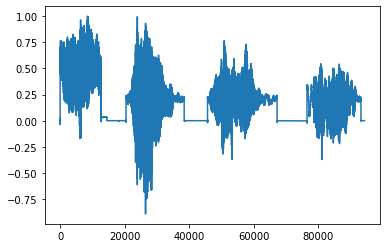

In [16]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())
plt.show()

### Downsampling the audio

Our audios has a sample rate of `16000`, which is very huge and it is not effient to train the network on such a sample rate. We can downsample the sample rate so that we will be using the `touchaudio.transforms.Resample` method and change the sample rate to `8000`.

In [17]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate,
                                           new_freq=new_sample_rate)
transformed = transform(waveform)

# playing the original sound
play_audio(waveform, sample_rate)

### Playing the transformed sound

In [18]:
play_audio(transformed, new_sample_rate )

### Creating a dataset

We are going to create a dataset using the `Dataset` class from `torch.utils.data` we are going to call our dataset `CatsDogsAudio`, This dataset class will take in data, and transform as it's argument.

1. data
* this is essentially a list of loaded data. example is `train_data` 

2. transform

* these are transforms that we are going to apply on our features and labels.

In [19]:
class CatsDogsAudio(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.len = len(data)
    self.x = [i[0].numpy() for i in self.data]
    self.y = [i[-1] for i in self.data]
    self.transform = transform
      
  def __getitem__(self, index):
    sample = self.x[index], self.y[index]
    
    if self.transform:
        sample = self.transform(sample)
    return sample
  
  def __len__(self):
    return self.len
        

### Transform
We are going to create a `ToTensor` custom transform that will convert features and labels to tensors.

In [20]:
class ToTensor:
  def __call__(self, samples):
    x, y = samples
    return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y, dtype='float32'))

### Train and Test dataset

Now we can be able to create our train and test data using the `CatsDogsAudio` dataset.

In [21]:
train = CatsDogsAudio(data=train_data, transform=ToTensor())
test  = CatsDogsAudio(data=test_data, transform=ToTensor())

### Checking examples in each set.

In [22]:
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  for row in data:
    table.add_row(row)
  print(table)


column_names = ["SUBSET", "EXAMPLE(s)"]
data = [
        ["training", len(train)],
        ['validation/test', len(test)],
]
tabulate(column_names, data)

+-----------------+------------+
|      SUBSET     | EXAMPLE(s) |
+-----------------+------------+
|     training    |    210     |
| validation/test |     67     |
+-----------------+------------+


### Checking a single example in the train data.

In [23]:
train[0]

(tensor([[-0.0016, -0.0011, -0.0005,  ...,  0.0180,  0.0242,  0.0217]]),
 tensor(0.))

### Playing the audion of the single example in the train.

> Remember class `0` is for cats and `1` is for dogs.

In [24]:
play_audio(train[0][0], sample_rate)

### Creating loaders
We are then going to create two loaders, the train and the test loaders for each set. Each loader will have a `collate_fn` which is more like a preprocessing function that is applied to the data by the `DataLoader` class from `torch.utils.data`


1. pad_sequence
* The audio's that wecare working with are of different length, so we need to use the `pad_sequences` from `torch.nn.utils.rnn` so that we make sure that short audios are padded with `0's`. in the `torch.nn.utils.rnn.pad_sequences` function we are going to set `batch_first` to true, this is because we are going to use `Conv1` layers and `Conv` layers expect the batch_size to be first.

2. collate_fn

In this function we are going to `transform` our audio waveforms and then apply the `pad_sequence` function.

In [25]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0, 2, 1)

def collate_fn(batch):
  tensors, targets = [], []

  for waveform, label in batch:
    # apply the transformations, by downsampling the wavefor from sample_rate 16000 to 8000
    tensors += [transform(waveform)]
    targets += [label]
  tensors = pad_sequence(tensors)
  targets = torch.stack(targets)
  return tensors, targets

### Loaders

We are going to use the batch_size of 8 since our dataset is smalle.

In [26]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

### Checking a single example in a batch.

In [27]:
next(iter(train_loader))

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-6.6234e-06, -2.1177e-05, -1.5447e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         ...,
 
         [[-4.3746e-03, -7.2753e-04, -1.0273e-02,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-2.0503e-05,  3.4004e-05,  5.6206e-05,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.0800e-03,
            7.2685e-03,  4.1220e-03]]]),
 tensor([0., 1., 0., 0., 0., 0., 1., 0.]))

### Creating a Model (`M5`)

We are going to use a Convolutional neural network to process the raw audio data. Usually more advanced transforms are applied to the audio data, however CNNs can be used to accurately process the raw data. The specific architecture is modeled after the M5 network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf).


In [28]:
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
    super(M5, self).__init__()
    self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
    self.bn1 = nn.BatchNorm1d(n_channel)
    self.pool1 = nn.MaxPool1d(4)

    self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(n_channel)
    self.pool2 = nn.MaxPool1d(4)

    self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
    self.bn3 = nn.BatchNorm1d(2 * n_channel)
    self.pool3 = nn.MaxPool1d(4)

    self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
    self.bn4 = nn.BatchNorm1d(2 * n_channel)
    self.pool4 = nn.MaxPool1d(4)

    self.fc1 = nn.Linear(2 * n_channel, n_output)


  def forward(self, x):
    x = self.conv1(x)
    x = Functional.relu(self.bn1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = Functional.relu(self.bn2(x))
    x = self.pool2(x)
    x = self.conv3(x)
    x = Functional.relu(self.bn3(x))
    x = self.pool3(x)
    x = self.conv4(x)
    x = Functional.relu(self.bn4(x))
    x = self.pool4(x)
    x = Functional.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    x = self.fc1(x)
    return x 

### Model instance

> Note that the `n_input=1` and `n_output=1` since this is a binary classification with `1d` input.

In [29]:
model = M5(n_input=transformed.shape[0], n_output=1).to(device)
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

### Counting model parameters

In [30]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 24,705
Total tainable parameters: 24,705


### Optimizer
 We are going to use the `Adam` optimizer with the default parameters

### Criterion

We are going to use the `BCEWithLogitsLoss` as our loss function since this is a binary classification task.

In [31]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

### Accuracy Function

We are going to compute the accuracy of the predicted values, with the actual labels or targets using the following function.

In [32]:
def binary_accuracy(y_preds, y_true):
  #round predictions to the closest integer
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float() #convert into float for division 
  acc = correct.sum() / len(correct)
  return acc

### Train and evaluation functions

Our train and evaluation functions are defined in the following code cell.

1. train
* This is a function that takes in the `model`, `optimizer`, `iterator` and `criterion` and return the train loss and train accuracy.

* first we put the model in the `train` mode by calling `model.train()`
* We the iterate over an `iterator` and put features and labels to the device
* We restore the gradients by calling the `optimizer.zero_grad()` function
* We make the predictions and calculate the loss and accuracy for each iterator
* After the loop we return the loss of each epoch and the accuracy


2. evaluate
* This is a function that takes in the `model`, `iterator` and `criterion` and return the train loss and train accuracy.

* We call the `model.eval()` so that the model will be in the evaluation mode.
* We don't need to compute the gradi ents during evaluation so we wrap our iteration with `with torch.no_grad()` function
* We the iterate over an `iterator` and put features and labels to the device
* We make the predictions and calculate the loss and accuracy for each iterator
* After the loop we return the loss of each epoch and the accuracy


In [33]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for X, y in iterator:
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    predictions = model(X).squeeze()
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for X, y in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X).squeeze()
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training

We will create two helper functions that will helps us to visualize our training.

1. hms_string

In [34]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

2. visualize_training

In [35]:
def visualize_training(start, end, train_loss, train_accuracy, val_loss, val_accuracy, title):
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_accuracy:.3f}', f"{hms_string(end - start)}" ],
       ["Validation", f'{val_loss:.3f}', f'{val_accuracy:.3f}', "" ],       
  ]
  table = PrettyTable(["CATEGORY", "LOSS", "ACCURACY", "ETA"])
  table.align["CATEGORY"] = 'l'
  table.align["LOSS"] = 'r'
  table.align["ACCURACY"] = 'r'
  table.align["ETA"] = 'r'
  table.title = title
  for row in data:
    table.add_row(row)
  print(table)

### The train loop

We are going to train our model for `15` epochs. We check on evry epoch if the loss has decreased and save the model as `cats-dogs-soud.pt` file.

In [36]:
N_EPOCHS = 15
MODEL_NAME = "cats-dogs-sound.pt"
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(model, 
                                train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, 
                                    test_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  visualize_training(start, end, train_loss, train_acc, valid_loss, valid_acc, title)

+--------------------------------------------+
|     EPOCH: 01/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.577 |    0.773 | 0:00:02.40 |
| Validation | 0.618 |    0.833 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.434 |    0.880 | 0:00:02.88 |
| Validation | 0.373 |    0.917 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/15 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   

### Downloading the model

We are going to download the `best-model` as a static file.

In [37]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model inference
Now we can make preditions using our model. So to make predictions we need to preprocess the data in a way that we did during data preparation for training. We are going to do the following


1. pad the  sequences to the longest sequence
2. transform the sequences by reducing the wave_length



In [38]:
def pad_sequence(batch):
  batch = torch.nn.utils.rnn.pad_sequence([batch], batch_first=True, padding_value=0.)
  return batch

def preprocess(waveform):
  waveform = pad_sequence(waveform)
  return transform(waveform)

### Predict label function

Our `predict_label` function will take in the `model` and the `waveform` and return the following `json` as a pretiction.

```json
{'class': 'cat', 'label': 0, 'probability': 0.96}
```



In [39]:
classes = ["cat", "dog"]

def predict_label(model, waveform):
  processed = preprocess(waveform).to(device)
  model.eval()
  with torch.no_grad():
    prediction = torch.sigmoid(model(processed).squeeze())
    probability = float(prediction.item()) if prediction.item() > .5 else 1 - prediction.item()
    label = 1 if prediction.item() >= 0.5 else 0
    pred =  {
        'label': label,
        'class': classes[label],
        'probability':round(probability, 2),
    }
    return pred

predict_label(model, train_data[0][0])

{'class': 'cat', 'label': 0, 'probability': 0.96}

### Checking if the sound is surely for a cat

In [40]:
play_audio(train_data[0][0], sample_rate)

### Prediction a dog sound

In [41]:
predict_label(model, train_data[1][0])

{'class': 'dog', 'label': 1, 'probability': 1.0}

In [42]:
play_audio(train_data[1][0], sample_rate)

#### The Confusion Matrix

We can now make the Confusion matrix for this model.

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [44]:
def plot_confusion_matrix(labels:list, pred_labels:list, classes:list=[]):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)

  if len(classes) == 0:
    classes = labels.numpy()

  cm = ConfusionMatrixDisplay(cm, display_labels= classes)
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20, color="black", fontsize=15)
  plt.yticks(rotation = 20, color="black", fontsize=15)

In [45]:
y_true =[]
y_preds = []

for X, _, __, y in test_data:
  X = preprocess(X)
  X = X.to(device)
  y_true.append(y)

  prediction = torch.sigmoid(model(X).squeeze())
  label = 1 if prediction.item() >= 0.5 else 0
  y_preds.append(label)


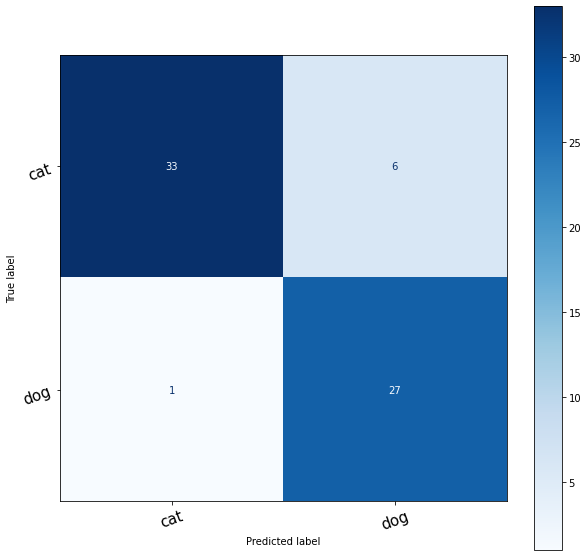

In [46]:
plot_confusion_matrix(y_true, y_preds, classes)

### Classification report.

In [47]:
from sklearn.metrics import classification_report

In [48]:
cr = classification_report(y_true, y_preds, output_dict=False, labels=y_true, target_names =[classes[i] for i in y_true])
print(cr)

              precision    recall  f1-score   support

         dog       0.82      0.96      0.89        28
         cat       0.97      0.85      0.90        39
         dog       0.82      0.96      0.89        28
         dog       0.82      0.96      0.89        28
         cat       0.97      0.85      0.90        39
         dog       0.82      0.96      0.89        28
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         dog       0.82      0.96      0.89        28
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         dog       0.82      0.96      0.89        28
         cat       0.97      0.85      0.90        39
         cat       0.97      0.85      0.90        39
         dog       0.82    

### Refs

The following list of notebooks and Readmes was used as reference to this notebook


1. [02_Sentiment_Analyisis_Series](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/02_Sentiment_Analyisis_Series/03_Faster_Sentiment_Analyisis.ipynb)
2. [01_Speech_Commend_Recognition](https://github.com/CrispenGari/pytorch-python/blob/main/10_AUDIO/01_SPEECH_RECOGNITION/01_Speech_Commend_Recognition.ipynb)
3. [tabulate-data](https://github.com/CrispenGari/ml-utils/tree/main/tabulate-data)
4. [simple-plot-confusion-matrix](https://github.com/CrispenGari/ml-utils/tree/main/simple-plot-confusion-matrix)